# DIC Analysis

#### Overview of what this notebook does:
- Uses functions from previous work to load in the data from npy files
- Some of these functions were then amended to work for data that had already been loaded in (rather than having to load the data each time)
- Functions were then produced to plot stress-strain curves from this data
<br>
<br>Then for each sample:
- A stress strain was plotted for the whole sample (i.e. with a ROI of (0,-1,0,-1), or in some cases (1,-2,1,-2)), and this was compared to the stress-strain curve of the instron data
- A deformation map of the whole sample was then plotted, and from this a ROI selected where the fracture took place. Across all samples the ROIs were kept a consistant size of 28x28 pixels
- The data (for the ROI only) is then cropped at the point of failure
- A stress strain curve was then plotted for the ROI only, and again this was compared to the (cropped) stress-strain curve of the instron data
<br>
<br>
- The  engineering stress-strain graphs for the ROIs of the DIC data are then compared by direction and by sample
- The data is then converted to true stress and strain and these curves are then compared as well

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress
%matplotlib inline

### Functions from Previous Work

In [2]:
def load_voltage_data(file_name: str):
    data_setrda=pd.read_csv(file_name, skiprows=1).values
    time = data_setrda[:,0] - data_setrda[0,0]
    voltage = data_setrda[:,1]
    return time, voltage

def load_instron_data(file_name: str):
    instron_setrda = pd.read_csv(file_name, skiprows=9).values
    instron_time = instron_setrda[:,0] * 1e3
    stress = instron_setrda[:,3]
    return instron_time, stress

def mask_data(stress, voltage):
    low_percentile = 5
    high_percentile = 22
    stress_mask = (int(len(stress) / 100 * low_percentile), int(len(stress) / 100 * high_percentile))
    voltage_mask = (int(len(voltage) / 100 * low_percentile), int(len(voltage) / 100 * high_percentile))
    return stress_mask, voltage_mask

def linear_regression(x, y, mask):
    gradient = linregress(x[mask[0]:mask[1]], y[mask[0]:mask[1]])
    return gradient

def get_voltage_scaling(dic_voltage_file, instron_file):    
    time, voltage = load_voltage_data(dic_voltage_file)
    instron_time, stress = load_instron_data(instron_file)
    #plot_data(time, voltage, instron_time, stress, name)
    stress_mask, voltage_mask = mask_data(stress, voltage)
    #plot_masked_data(time, voltage, voltage_mask, instron_time, stress, stress_mask)
    voltage_gradient = linear_regression(time, voltage,voltage_mask)
    stress_gradient = linear_regression(instron_time, stress, stress_mask)
    scaling_factor = stress_gradient.slope / voltage_gradient.slope
    return scaling_factor

class Deformation_map():
    def __init__(self,path,fname) :
        self.xtrim = 0
        self.ytrim = 0
        self.path = path
        self.fname = fname
        file = open(self.path+'/'+self.fname,encoding='iso-8859-1')
        self.data = np.loadtxt(file, skiprows=1, delimiter=',')
        self.xc = self.data[:,0]
        self.yc = self.data[:,1]
        self.xd = self.data[:,2]
        self.yd = self.data[:,3]
        binning_x = min(abs(np.diff(self.xc)))
        binning_y = max(abs(np.diff(self.yc)))
        assert binning_x == binning_y
        assert binning_x % 1 == 0
        self.binning = int(binning_x)      
        self.xdim = int((self.xc.max() - self.xc.min()) / binning_x) + 1
        self.ydim = int((self.yc.max() - self.yc.min()) / binning_y) + 1
        #self.x_map = self._map(self.xd)
        #self.y_map = self._map(self.yd)
        self.x_map, _ = self._map_wmissing(self.xd)
        self.y_map, _ = self._map_wmissing(self.yd)
        self.f11 = self._grad(self.x_map)[1]
        self.f22 = self._grad(self.y_map)[0]
        self.f12 = self._grad(self.x_map)[0]
        self.f21 = self._grad(self.y_map)[1]
        self.max_shear = np.sqrt((((self.f11-self.f22)/2.)**2) + ((self.f12+self.f21)/2.)**2)
        self.max_shear = self.max_shear[self.ytrim:-self.ytrim,self.xtrim:-self.xtrim]
        self.mapshape = np.shape(self.max_shear)
    def _map(self,data_col,ydim,xdim):
        data_map=np.reshape(np.array(data_col),(int(ydim),int(xdim)))
        return data_map
    def _map_wmissing(self, data_col):
        data_map = np.full((self.ydim, self.xdim), np.nan)
        xc = self.xc - self.xc.min()
        yc = self.yc - self.yc.min()
        locs = []
        for val, x, y in zip(data_col, xc, yc):
            loc = tuple(int(d / self.binning) for d in (x, y))
            if loc in locs:
                print("Multiple data values for 1 point.")
            else:
                locs.append(loc)
            data_map[loc[1], loc[0]] = val
        return data_map, locs
    def _grad(self,data_map) :
        grad_step=min(abs((np.diff(self.xc))))
        data_grad=np.gradient(data_map,grad_step,grad_step)
        return data_grad

def average_strains(sequence,roi):
    yStart=roi[0]
    yEnd=roi[1]
    xStart=roi[2]
    xEnd=roi[3]
    e11=np.empty(np.size(sequence))
    e22=np.empty(np.size(sequence))
    for k,data in enumerate(sequence):
        e11[k]=np.log(np.mean(data.f22[yStart:yEnd,xStart:xEnd].ravel())+1)
        e22[k]=np.log(np.mean(data.f11[yStart:yEnd,xStart:xEnd].ravel())+1)
    return e11,e22

def load_macro_dic(ROI,deformation_sequence, instron_file, voltage_file):
    deformation_maps = np.load(deformation_sequence, allow_pickle=True)
    voltage_scaling = get_voltage_scaling(voltage_file, instron_file)
    time, voltage = load_voltage_data(voltage_file)
    stress_data = voltage*voltage_scaling
    strain_1, strain_2 = average_strains(deformation_maps, roi = ROI)
    average_strain_data=[strain_1, strain_2]
    return deformation_maps, stress_data, average_strain_data

### Loading Data

In [3]:
RD_A_npz = np.load('../Data/DIC/npz_files/RD_Timet_A.npz', allow_pickle=True)['arr_0']
RD_B_npz = np.load('../Data/DIC/npz_files/RD_Timet_B.npz', allow_pickle=True)['arr_0']
TD_A_npz = np.load('../Data/DIC/npz_files/TD_Timet_A.npz', allow_pickle=True)['arr_0']
TD_B_npz = np.load('../Data/DIC/npz_files/TD_Timet_B.npz', allow_pickle=True)['arr_0']
FFD_A_npz = np.load('../Data/DIC/npz_files/45degree_Timet_A.npz', allow_pickle=True)['arr_0']
FFD_B_npz = np.load('../Data/DIC/npz_files/45degree_Timet_B.npz', allow_pickle=True)['arr_0']

In [4]:
RD_A_Time, RD_A_Voltage = load_voltage_data('../Data/DIC/Voltage/RD_Timet_A_Voltage.csv')
RD_B_Time, RD_B_Voltage = load_voltage_data('../Data/DIC/Voltage/RD_Timet_B_Voltage.csv')
TD_A_Time, TD_A_Voltage = load_voltage_data('../Data/DIC/Voltage/TD_Timet_A_Voltage.csv')
TD_B_Time, TD_B_Voltage = load_voltage_data('../Data/DIC/Voltage/TD_Timet_B_Voltage.csv')
FFD_A_Time, FFD_A_Voltage = load_voltage_data('../Data/DIC/Voltage/45degree_Timet_A_Voltage.csv')
FFD_B_Time, FFD_B_Voltage = load_voltage_data('../Data/DIC/Voltage/45degree_Timet_B_Voltage.csv')

In [5]:
RD_A_Voltage_Scaling = get_voltage_scaling('../Data/DIC/Voltage/RD_Timet_A_Voltage.csv','../Data/Instron/RD_Timet_A.csv')
RD_B_Voltage_Scaling = get_voltage_scaling('../Data/DIC/Voltage/RD_Timet_B_Voltage.csv','../Data/Instron/RD_Timet_B.csv')
TD_A_Voltage_Scaling = get_voltage_scaling('../Data/DIC/Voltage/TD_Timet_A_Voltage.csv','../Data/Instron/TD_Timet_A.csv')
TD_B_Voltage_Scaling = get_voltage_scaling('../Data/DIC/Voltage/TD_Timet_B_Voltage.csv','../Data/Instron/TD_Timet_B.csv')
FFD_A_Voltage_Scaling = get_voltage_scaling('../Data/DIC/Voltage/45degree_Timet_A_Voltage.csv','../Data/Instron/45degree_Timet_A.csv')
FFD_B_Voltage_Scaling = get_voltage_scaling('../Data/DIC/Voltage/45degree_Timet_B_Voltage.csv','../Data/Instron/45degree_Timet_B.csv')

In [6]:
RD_A_Instron = np.loadtxt('../Data/Instron/RD_Timet_A.csv', delimiter=',', skiprows=10)
RD_B_Instron = np.loadtxt('../Data/Instron/RD_Timet_B.csv', delimiter=',', skiprows=10)
TD_A_Instron = np.loadtxt('../Data/Instron/TD_Timet_A.csv', delimiter=',', skiprows=10)
TD_B_Instron = np.loadtxt('../Data/Instron/TD_Timet_B.csv', delimiter=',', skiprows=10)
FFD_A_Instron = np.loadtxt('../Data/Instron/45degree_Timet_A.csv', delimiter=',', skiprows=10)
FFD_B_Instron = np.loadtxt('../Data/Instron/45degree_Timet_B.csv', delimiter=',', skiprows=10)

### Modified Functions (for already loaded data)

In [7]:
def load_DIC(ROI,npz_data,voltage_data,voltage_scaling):
    deformation_maps = npz_data
    stress_data = voltage_data*voltage_scaling
    strain_1, strain_2 = average_strains(npz_data, roi = ROI)
    average_strain_data=[strain_1, strain_2]
    return deformation_maps, stress_data, average_strain_data

### Functions for Plotting

In [8]:
def plot_DIC(strain,stress):
    plt.plot(strain,stress,label='DIC')
    plt.xlabel("Strain")
    plt.ylabel("Stress (MPa)")
    plt.legend(loc='best')
    
def plot_instron(eng_strain,eng_stress):
    plt.plot((eng_strain/100),eng_stress, label="Instron")
    plt.xlabel("Strain")
    plt.ylabel("Stress (MPa)")
    plt.legend(loc='best')

### Sample A, Rolling Direction

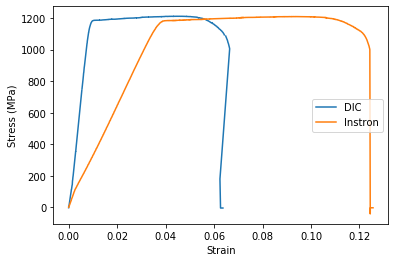

In [9]:
#Plotting Whole Sample
defmap,RD_A_Stress_Sample,RD_A_Strain_Sample = load_DIC((0,-1,0,-1),RD_A_npz,RD_A_Voltage,RD_A_Voltage_Scaling)
plot_DIC(RD_A_Strain_Sample[0],RD_A_Stress_Sample)
plot_instron(RD_A_Instron[:,9],RD_A_Instron[:,3])

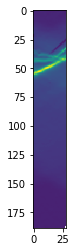

In [11]:
plt.imshow(RD_A_npz[-1].f22)
plt.savefig('RD_A_Strain_map.png');

(189, 28)


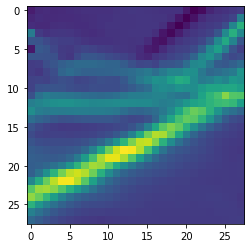

In [12]:
print(np.shape(RD_A_npz[-1].f22))
plt.imshow(RD_A_npz[-1].f22[31:59]);
#Means new ROI should be (31,59,0,28)

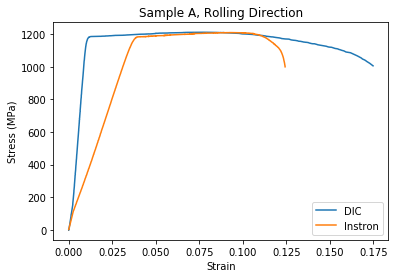

In [58]:
#Cropping and Plotting ROI (with cropped Instron)
defmap,RD_A_Stress_ROI,RD_A_Strain_ROI = load_DIC((31,59,0,28),RD_A_npz,RD_A_Voltage,RD_A_Voltage_Scaling)
RD_A_Stress_ROI_Cropped = RD_A_Stress_ROI[0:1124]
RD_A_Strain_ROI_Cropped = RD_A_Strain_ROI[0][0:1124]
plot_DIC(RD_A_Strain_ROI_Cropped,RD_A_Stress_ROI_Cropped)

RD_A_Eng_Stress_Cropped = RD_A_Instron[:,3][0:2238]
RD_A_Eng_Strain_Cropped = RD_A_Instron[:,9][0:2238]
plot_instron(RD_A_Eng_Strain_Cropped,RD_A_Eng_Stress_Cropped)
plt.title('Sample A, Rolling Direction')
plt.savefig('RD_A_Compare_Engineering_DIC_Instron.png');

### Sample B, Rolling Direction

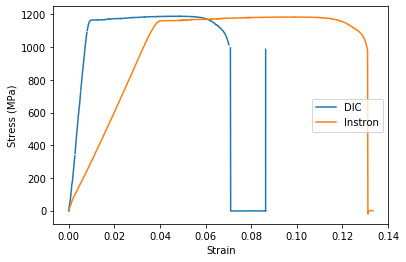

In [14]:
#Plotting Whole Sample
defmap,RD_B_Stress_Sample,RD_B_Strain_Sample = load_DIC((1,-2,1,-2),RD_B_npz[:-1],RD_B_Voltage,RD_B_Voltage_Scaling)
plot_DIC(RD_B_Strain_Sample[0],RD_B_Stress_Sample)
plot_instron(RD_B_Instron[:,9],RD_B_Instron[:,3])

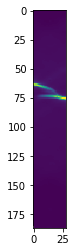

In [15]:
plt.imshow(RD_B_npz[-1].f22)
plt.savefig('RD_B_Strain_map.png');

(187, 28)


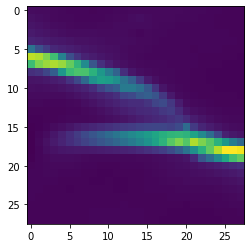

In [16]:
print(np.shape(RD_B_npz[-1].f22))
plt.imshow(RD_B_npz[-1].f22[57:85]);
#Means new ROI should be (57,85,0,28)

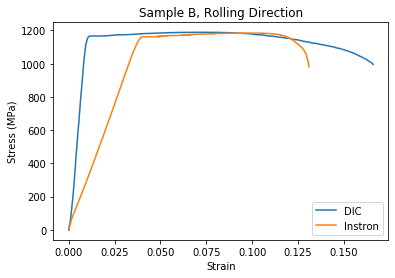

In [59]:
#Cropping and Plotting ROI (with cropped Instron)
defmap,RD_B_Stress_ROI,RD_B_Strain_ROI = load_DIC((57,85,0,28),RD_B_npz[:-1],RD_B_Voltage,RD_B_Voltage_Scaling)
RD_B_Stress_ROI_Cropped = RD_B_Stress_ROI[0:1191]
RD_B_Strain_ROI_Cropped = RD_B_Strain_ROI[0][0:1191]
plot_DIC(RD_B_Strain_ROI_Cropped,RD_B_Stress_ROI_Cropped)

RD_B_Eng_Stress_Cropped = RD_B_Instron[:,3][0:2359]
RD_B_Eng_Strain_Cropped = RD_B_Instron[:,9][0:2359]
plot_instron(RD_B_Eng_Strain_Cropped,RD_B_Eng_Stress_Cropped)
plt.title('Sample B, Rolling Direction')
plt.savefig('RD_B_Compare_Engineering_DIC_Instron.png');

### Sample A, Transverse Direction

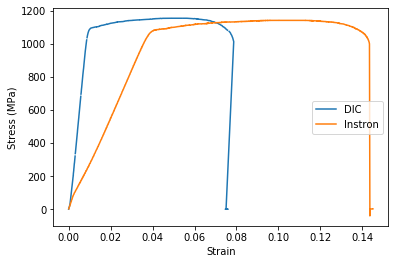

In [18]:
#Plotting Whole Sample
defmap,TD_A_Stress_Sample,TD_A_Strain_Sample = load_DIC((1,-2,1,-2),TD_A_npz[:-1],TD_A_Voltage,TD_A_Voltage_Scaling)
plot_DIC(TD_A_Strain_Sample[0],TD_A_Stress_Sample)
plot_instron(TD_A_Instron[:,9],TD_A_Instron[:,3])

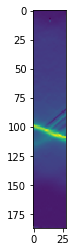

In [19]:
plt.imshow(TD_A_npz[-1].f22)
plt.savefig('TD_A_Strain_map.png');

(187, 28)


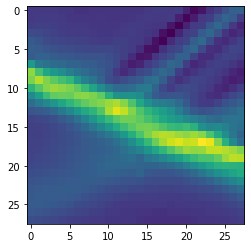

In [20]:
print(np.shape(TD_A_npz[-1].f22))
plt.imshow(TD_A_npz[-1].f22[90:118]);
#Means new ROI should be (90,118,0,28)

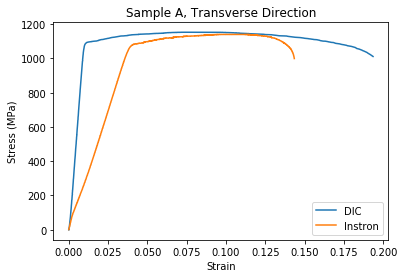

In [60]:
#Cropping and Plotting ROI (with cropped Instron)
defmap,TD_A_Stress_ROI,TD_A_Strain_ROI = load_DIC((90,118,0,28),TD_A_npz[:-1],TD_A_Voltage,TD_A_Voltage_Scaling)
TD_A_Stress_ROI_Cropped = TD_A_Stress_ROI[0:1308]
TD_A_Strain_ROI_Cropped = TD_A_Strain_ROI[0][0:1308]
plot_DIC(TD_A_Strain_ROI_Cropped,TD_A_Stress_ROI_Cropped)

TD_A_Eng_Stress_Cropped = TD_A_Instron[:,3][0:2582]
TD_A_Eng_Strain_Cropped = TD_A_Instron[:,9][0:2582]
plot_instron(TD_A_Eng_Strain_Cropped,TD_A_Eng_Stress_Cropped)
plt.title('Sample A, Transverse Direction')
plt.savefig('TD_A_Compare_Engineering_DIC_Instron.png');

### Sample B, Transverse Direction

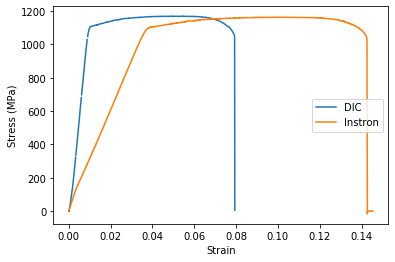

In [22]:
#Plotting Whole Sample
defmap,TD_B_Stress_Sample,TD_B_Strain_Sample = load_DIC((1,-2,1,-2),TD_B_npz[:-1],TD_B_Voltage,TD_B_Voltage_Scaling)
plot_DIC(TD_B_Strain_Sample[0],TD_B_Stress_Sample)
plot_instron(TD_B_Instron[:,9],TD_B_Instron[:,3])

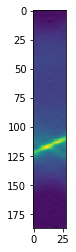

In [23]:
plt.imshow(TD_B_npz[-1].f22)
plt.savefig('TD_B_Strain_map.png');

(187, 28)


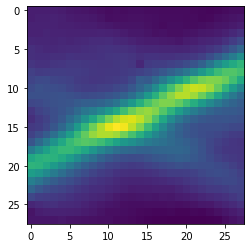

In [24]:
print(np.shape(TD_B_npz[-1].f22))
plt.imshow(TD_B_npz[-1].f22[102:130]);
#Means new ROI should be (102,130,0,28)

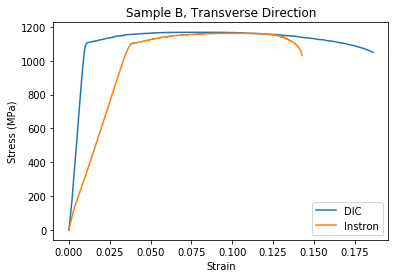

In [61]:
#Cropping and Plotting ROI (with cropped Instron)
defmap,TD_B_Stress_ROI,TD_B_Strain_ROI = load_DIC((102,130,0,28),TD_B_npz[:-1],TD_B_Voltage,TD_B_Voltage_Scaling)
TD_B_Stress_ROI_Cropped = TD_B_Stress_ROI[0:1303]
TD_B_Strain_ROI_Cropped = TD_B_Strain_ROI[0][0:1303]
plot_DIC(TD_B_Strain_ROI_Cropped,TD_B_Stress_ROI_Cropped)

TD_B_Eng_Stress_Cropped = TD_B_Instron[:,3][0:2568]
TD_B_Eng_Strain_Cropped = TD_B_Instron[:,9][0:2568]
plot_instron(TD_B_Eng_Strain_Cropped,TD_B_Eng_Stress_Cropped)
plt.title('Sample B, Transverse Direction')
plt.savefig('TD_B_Compare_Engineering_DIC_Instron.png');

### Sample A, 45 Degrees

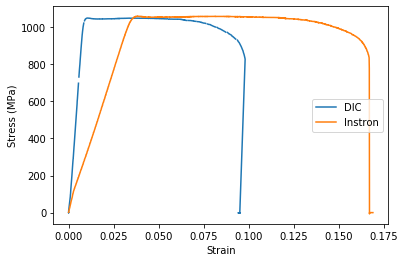

In [26]:
#Plotting Whole Sample
defmap,FFD_A_Stress_Sample,FFD_A_Strain_Sample = load_DIC((1,-2,1,-2),FFD_A_npz[:-1],FFD_A_Voltage,FFD_A_Voltage_Scaling)
plot_DIC(FFD_A_Strain_Sample[0],FFD_A_Stress_Sample)
plot_instron(FFD_A_Instron[:,9],FFD_A_Instron[:,3])

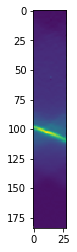

In [27]:
plt.imshow(FFD_A_npz[-1].f22)
plt.savefig('45deg_A_Strain_map.png');

(184, 28)


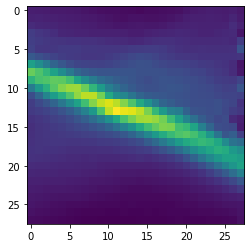

In [28]:
print(np.shape(FFD_A_npz[-1].f22))
plt.imshow(FFD_A_npz[-1].f22[90:118]);
#Means new ROI should be (90,118,0,28)

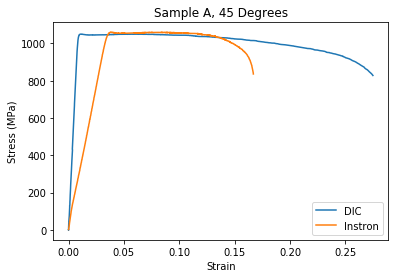

In [62]:
#Cropping and Plotting ROI (with cropped Instron)
defmap,FFD_A_Stress_ROI,FFD_A_Strain_ROI = load_DIC((90,118,0,28),FFD_A_npz[:-1],FFD_A_Voltage,FFD_A_Voltage_Scaling)
FFD_A_Stress_ROI_Cropped = FFD_A_Stress_ROI[0:1513]
FFD_A_Strain_ROI_Cropped = FFD_A_Strain_ROI[0][0:1513]
plot_DIC(FFD_A_Strain_ROI_Cropped,FFD_A_Stress_ROI_Cropped)

FFD_A_Eng_Stress_Cropped = FFD_A_Instron[:,3][0:3005]
FFD_A_Eng_Strain_Cropped = FFD_A_Instron[:,9][0:3005]
plot_instron(FFD_A_Eng_Strain_Cropped,FFD_A_Eng_Stress_Cropped)
plt.title('Sample A, 45 Degrees')
plt.savefig('45deg_A_Compare_Engineering_DIC_Instron.png');

### Sample B, 45 Degrees

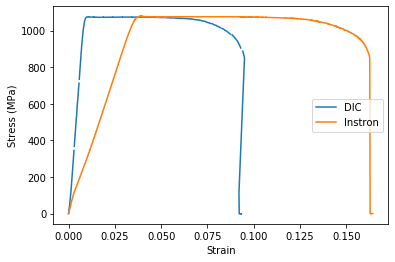

In [30]:
#Plotting Whole Sample
defmap,FFD_B_Stress_Sample,FFD_B_Strain_Sample = load_DIC((1,-2,1,-2),FFD_B_npz[:-1],FFD_B_Voltage,FFD_B_Voltage_Scaling)
plot_DIC(FFD_B_Strain_Sample[0],FFD_B_Stress_Sample)
plot_instron(FFD_B_Instron[:,9],FFD_B_Instron[:,3])

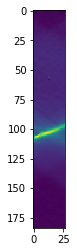

In [31]:
plt.imshow(FFD_B_npz[-1].f22)
plt.savefig('45deg_B_Strain_map.png');

(184, 27)


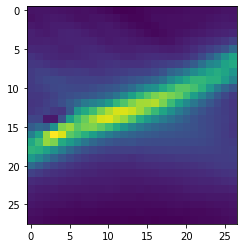

In [32]:
print(np.shape(FFD_B_npz[-1].f22))
plt.imshow(FFD_B_npz[-1].f22[90:118]);
#Means new ROI should be (90,118,0,28)

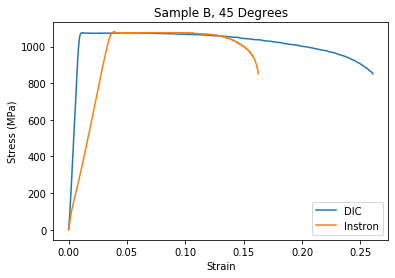

In [63]:
#Cropping and Plotting ROI (with cropped Instron)
defmap,FFD_B_Stress_ROI,FFD_B_Strain_ROI = load_DIC((90,118,0,28),FFD_B_npz[:-1],FFD_B_Voltage,FFD_B_Voltage_Scaling)
FFD_B_Stress_ROI_Cropped = FFD_B_Stress_ROI[0:1475]
FFD_B_Strain_ROI_Cropped = FFD_B_Strain_ROI[0][0:1475]
plot_DIC(FFD_B_Strain_ROI_Cropped,FFD_B_Stress_ROI_Cropped)

FFD_B_Eng_Stress_Cropped = FFD_B_Instron[:,3][0:2928]
FFD_B_Eng_Strain_Cropped = FFD_B_Instron[:,9][0:2928]
plot_instron(FFD_B_Eng_Strain_Cropped,FFD_B_Eng_Stress_Cropped)
plt.title('Sample B, 45 Degrees')
plt.savefig('45deg_B_Compare_Engineering_DIC_Instron.png');

#### Notes on what the above graphs show:
Across all of the samples, the final strain at failure is smaller for the whole sample DIC than for the whole sample in the Instron test. This is because the Instron test data also includes the elastic compliance of the machine, which is removed by doing the analysis with DIC.
<br> However, it can also be seen across all samples that the final strain at failure when just using the ROI is much larger than that of the Instron data, because the region being observed is where the strain is concentrated in the sample.

In [36]:
#The selected ROIs for each sample:
RD_A_ROI = (31,59,0,28)
RD_B_ROI = (57,85,0,28)
TD_A_ROI = (90,118,0,28)
TD_B_ROI = (102,130,0,28)
FFD_A_ROI = (90,118,0,28)
FFD_B_ROI = (90,118,0,28)

### Comparing the DIC graphs (Engineering Stress-Strain Data)

In [37]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

def plot_DIC_compare(strain,stress):
    if 'RD_A' in namestr(strain, globals()):
        name='Rolling Direction, Sample A'
    if 'RD_B' in namestr(strain, globals()):
        name='Rolling Direction, Sample B'
    if 'TD_A' in namestr(strain, globals()):
        name='Transverse Direction, Sample A'
    if 'TD_B' in namestr(strain, globals()):
        name='Transverse Direction, Sample B'
    if 'FFD_A' in namestr(strain, globals()):
        name='45 Degrees, Sample A'
    if 'FFD_B' in namestr(strain, globals()):
        name='45 Degrees, Sample B'
    plt.plot(strain,stress,label=name)
    plt.xlabel("Strain")
    plt.ylabel("Stress (MPa)")
    plt.legend(loc='best')

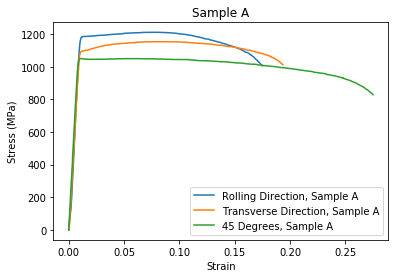

In [38]:
plot_DIC_compare(RD_A_Strain_ROI_Cropped,RD_A_Stress_ROI_Cropped)
plot_DIC_compare(TD_A_Strain_ROI_Cropped,TD_A_Stress_ROI_Cropped)
plot_DIC_compare(FFD_A_Strain_ROI_Cropped,FFD_A_Stress_ROI_Cropped)
plt.title('Sample A')
plt.savefig('Sample_A_Engineering_DIC.png');

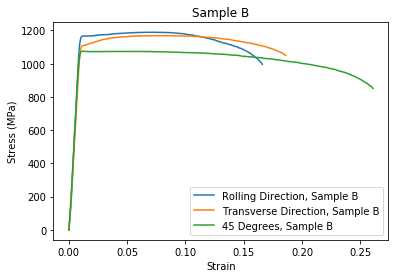

In [40]:
plot_DIC_compare(RD_B_Strain_ROI_Cropped,RD_B_Stress_ROI_Cropped)
plot_DIC_compare(TD_B_Strain_ROI_Cropped,TD_B_Stress_ROI_Cropped)
plot_DIC_compare(FFD_B_Strain_ROI_Cropped,FFD_B_Stress_ROI_Cropped)
plt.title('Sample B')
plt.savefig('Sample_B_Engineering_DIC.png');

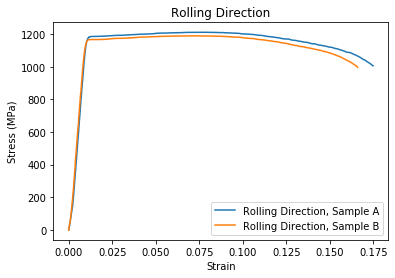

In [41]:
plot_DIC_compare(RD_A_Strain_ROI_Cropped,RD_A_Stress_ROI_Cropped)
plot_DIC_compare(RD_B_Strain_ROI_Cropped,RD_B_Stress_ROI_Cropped)
plt.title('Rolling Direction')
plt.savefig('RD_Engineering_DIC.png');

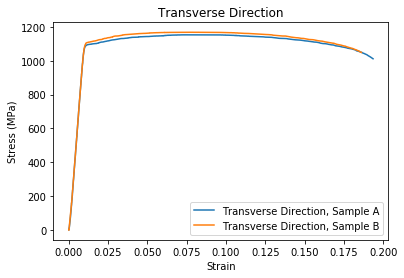

In [42]:
plot_DIC_compare(TD_A_Strain_ROI_Cropped,TD_A_Stress_ROI_Cropped)
plot_DIC_compare(TD_B_Strain_ROI_Cropped,TD_B_Stress_ROI_Cropped)
plt.title('Transverse Direction')
plt.savefig('TD_Engineering_DIC.png');

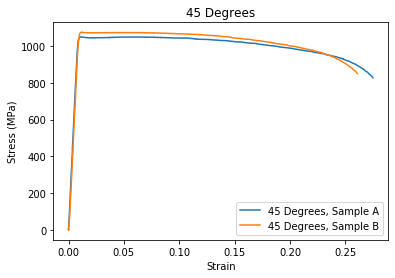

In [43]:
plot_DIC_compare(FFD_A_Strain_ROI_Cropped,FFD_A_Stress_ROI_Cropped)
plot_DIC_compare(FFD_B_Strain_ROI_Cropped,FFD_B_Stress_ROI_Cropped)
plt.title('45 Degrees')
plt.savefig('45deg_Engineering_DIC.png');

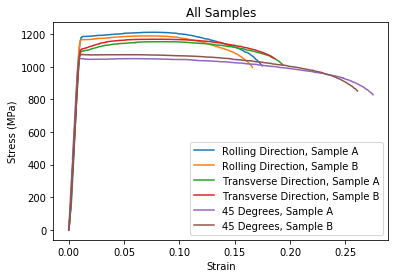

In [47]:
plot_DIC_compare(RD_A_Strain_ROI_Cropped,RD_A_Stress_ROI_Cropped)
plot_DIC_compare(RD_B_Strain_ROI_Cropped,RD_B_Stress_ROI_Cropped)
plot_DIC_compare(TD_A_Strain_ROI_Cropped,TD_A_Stress_ROI_Cropped)
plot_DIC_compare(TD_B_Strain_ROI_Cropped,TD_B_Stress_ROI_Cropped)
plot_DIC_compare(FFD_A_Strain_ROI_Cropped,FFD_A_Stress_ROI_Cropped)
plot_DIC_compare(FFD_B_Strain_ROI_Cropped,FFD_B_Stress_ROI_Cropped)
plt.title('All Samples')
plt.savefig('All_Samples_Engineering_DIC.png');

### Converting to True Stress-Strain

In [48]:
def true_stress(stress,strain):
    return stress*(1+(strain))
def true_strain(strain):
    return (np.log(1+(strain)))

RD_A_True_Stress = true_stress(RD_A_Stress_ROI_Cropped,RD_A_Strain_ROI_Cropped)
RD_A_True_Strain = true_strain(RD_A_Strain_ROI_Cropped)
RD_B_True_Stress = true_stress(RD_B_Stress_ROI_Cropped,RD_B_Strain_ROI_Cropped)
RD_B_True_Strain = true_strain(RD_B_Strain_ROI_Cropped)

TD_A_True_Stress = true_stress(TD_A_Stress_ROI_Cropped,TD_A_Strain_ROI_Cropped)
TD_A_True_Strain = true_strain(TD_A_Strain_ROI_Cropped)
TD_B_True_Stress = true_stress(TD_B_Stress_ROI_Cropped,TD_B_Strain_ROI_Cropped)
TD_B_True_Strain = true_strain(TD_B_Strain_ROI_Cropped)

FFD_A_True_Stress = true_stress(FFD_A_Stress_ROI_Cropped,FFD_A_Strain_ROI_Cropped)
FFD_A_True_Strain = true_strain(FFD_A_Strain_ROI_Cropped)
FFD_B_True_Stress = true_stress(FFD_B_Stress_ROI_Cropped,FFD_B_Strain_ROI_Cropped)
FFD_B_True_Strain = true_strain(FFD_B_Strain_ROI_Cropped)

### Comparing the DIC graphs (True Stress-Strain Data)

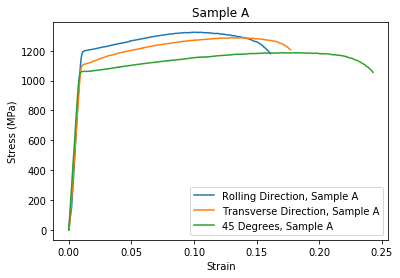

In [49]:
plot_DIC_compare(RD_A_True_Strain,RD_A_True_Stress)
plot_DIC_compare(TD_A_True_Strain,TD_A_True_Stress)
plot_DIC_compare(FFD_A_True_Strain,FFD_A_True_Stress)
plt.title('Sample A')
plt.savefig('Sample_A_True_DIC.png');

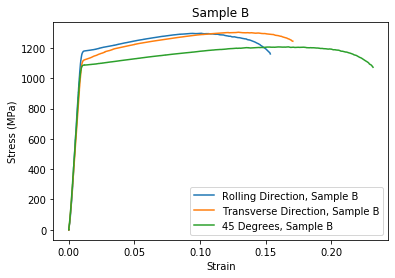

In [50]:
plot_DIC_compare(RD_B_True_Strain,RD_B_True_Stress)
plot_DIC_compare(TD_B_True_Strain,TD_B_True_Stress)
plot_DIC_compare(FFD_B_True_Strain,FFD_B_True_Stress)
plt.title('Sample B')
plt.savefig('Sample_B_True_DIC.png');

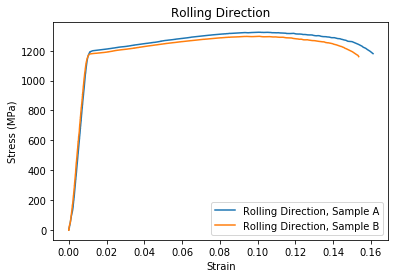

In [51]:
plot_DIC_compare(RD_A_True_Strain,RD_A_True_Stress)
plot_DIC_compare(RD_B_True_Strain,RD_B_True_Stress)
plt.title('Rolling Direction')
plt.savefig('RD_True_DIC.png');

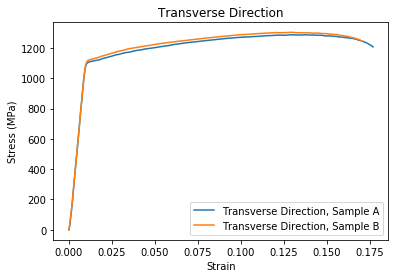

In [52]:
plot_DIC_compare(TD_A_True_Strain,TD_A_True_Stress)
plot_DIC_compare(TD_B_True_Strain,TD_B_True_Stress)
plt.title('Transverse Direction')
plt.savefig('TD_True_DIC.png');

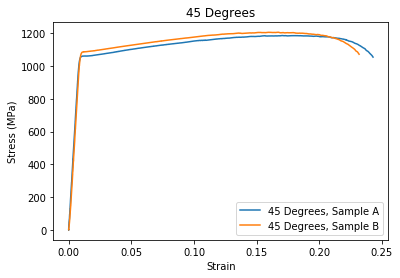

In [53]:
plot_DIC_compare(FFD_A_True_Strain,FFD_A_True_Stress)
plot_DIC_compare(FFD_B_True_Strain,FFD_B_True_Stress)
plt.title('45 Degrees')
plt.savefig('45deg_True_DIC.png');

From these comparison graphs, the following oberservations can be made:
- Similarly to the Instron data, the graphs comparing samples for each direction are much closer in shape than the graphs comparing directions for each sample.
- This means that the repeats were fairly accuracte, and hance the data comparing the different directions can be used to make overservations about the dutility. 
- Both samples A and B show that the samples tested in the rolling direction had the highest yeild.
- The rolling and transverse directions have higher work hardening than 45 degrees. 
- In both cases, the sample tested at 45 degrees showed the longest elongation to failure.
- The Young's modulus was very consistant for all three directions. 

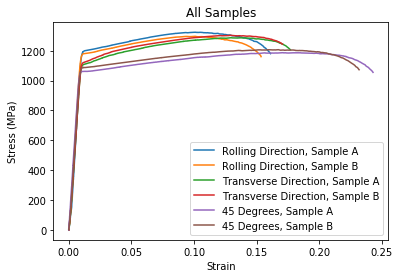

In [55]:
plot_DIC_compare(RD_A_True_Strain,RD_A_True_Stress)
plot_DIC_compare(RD_B_True_Strain,RD_B_True_Stress)
plot_DIC_compare(TD_A_True_Strain,TD_A_True_Stress)
plot_DIC_compare(TD_B_True_Strain,TD_B_True_Stress)
plot_DIC_compare(FFD_A_True_Strain,FFD_A_True_Stress)
plot_DIC_compare(FFD_B_True_Strain,FFD_B_True_Stress)
plt.title('All Samples')
plt.savefig('All_Samples_True_DIC.png');